# *Mount drive and go into folder
Note: parts with * are often not run

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/smishingAI/MachineLearningDev/CombinedModels/1. MsgPredict

In [ ]:
from utils import *
from list_of_functions import *
pipeline = ModelPipeline()

# Importing libraries (starts here)

In [1]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

For feature engineering

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Natas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Natas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Natas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading data

In [3]:
dataset_path='DatasetCombined.csv'
df = pd.read_csv(dataset_path, encoding='ISO-8859-1')
df.head()

,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,smishing,Please Stay At Home. To encourage the notion o...,yes,No,No


# Data exploration

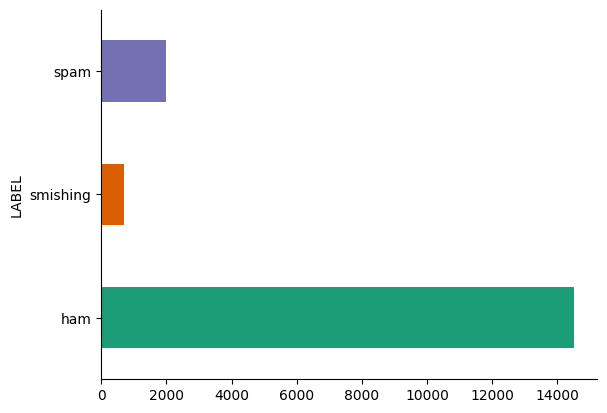

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('LABEL').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


Data is imbalanced

# Feature engineering

## URL


### Extract URLs from text

In [5]:
# Extract URLs from the text
df['URL'] = df['TEXT'].str.extract(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)')

# Remove URLs from the text
df['TEXT'] = df['TEXT'].str.replace(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)', '')

# Replace NaN values with an empty string
df['URL'] = df['URL'].fillna('')

# Replace NaN values with an empty string (to check results)
# df = df[df['URL'] != '']
df

,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,,No,No
1,ham,What's up? Do you want me to come online? If y...,,No,No
2,ham,So u workin overtime nigpun?,,No,No
3,ham,"Also sir, i sent you an email about how to log...",,No,No
4,smishing,Please Stay At Home. To encourage the notion o...,,No,No
...,...,...,...,...,...
17155,spam,This is the 2nd time we have tried 2 contact u...,,NaN,NaN
17156,ham,Will Ì_ b going to esplanade fr home?,,NaN,NaN
17157,ham,"Pity, * was in mood for that. So...any other s...",,NaN,NaN
17158,ham,The guy did some bitching but I acted like i'd...,,NaN,NaN


### url feature extraction

#### Phishing URL detection

In [6]:
import pickle

# Load the pickled model
with open('url_voting_classifier.pkl', 'rb') as file:
    url_model = pickle.load(file)

with open('url_tfidf_vectorizer.pkl', 'rb') as file:
    url_tfidf_vectorizer = pickle.load(file)

C:\Users\Natas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Natas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BernoulliNB from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Natas\AppDa

In [7]:
# Use the model to detect the URL column

# Define a function to extract features and predict
def predict_url(url, model):
    if not url:
        return None
    url_features = url_tfidf_vectorizer.transform([url])
    feature_values = url_features.toarray()[0]
    return model.predict([feature_values])[0]

# Apply the function to the URL column
df['URL_Detection'] = pd.to_numeric(df['URL'].apply(lambda x: predict_url(x, url_model)))

# Fill NaN values with -1
df['URL_Detection'] = pd.to_numeric(df['URL_Detection'].fillna(-1))

df

,LABEL,TEXT,URL,EMAIL,PHONE,URL_Detection
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,,No,No,-1.0
1,ham,What's up? Do you want me to come online? If y...,,No,No,-1.0
2,ham,So u workin overtime nigpun?,,No,No,-1.0
3,ham,"Also sir, i sent you an email about how to log...",,No,No,-1.0
4,smishing,Please Stay At Home. To encourage the notion o...,,No,No,-1.0
...,...,...,...,...,...,...
17155,spam,This is the 2nd time we have tried 2 contact u...,,NaN,NaN,-1.0
17156,ham,Will Ì_ b going to esplanade fr home?,,NaN,NaN,-1.0
17157,ham,"Pity, * was in mood for that. So...any other s...",,NaN,NaN,-1.0
17158,ham,The guy did some bitching but I acted like i'd...,,NaN,NaN,-1.0


In [8]:
df_with_url_detection = df[df['URL_Detection'].notnull()]
print(df_with_url_detection.head(100))

df[df['URL_Detection'].notnull()]

       LABEL                                               TEXT URL EMAIL   
0        ham  Your opinion about me? 1. Over 2. Jada 3. Kusr...        No  \
1        ham  What's up? Do you want me to come online? If y...        No   
2        ham                       So u workin overtime nigpun?        No   
3        ham  Also sir, i sent you an email about how to log...        No   
4   smishing  Please Stay At Home. To encourage the notion o...        No   
..       ...                                                ...  ..   ...   
95       ham  IM GONNAMISSU SO MUCH!!I WOULD SAY IL SEND U A...        No   
96       ham                        Dude we should go sup again        No   
97  smishing  You are being contacted by our dating service ...        No   
98       ham  Shopping lor. Them raining mah hard 2 leave or...        No   
99       ham  What's up my own oga. Left my phone at home an...        No   

   PHONE  URL_Detection  
0     No           -1.0  
1     No           -1.0

,LABEL,TEXT,URL,EMAIL,PHONE,URL_Detection
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,,No,No,-1.0
1,ham,What's up? Do you want me to come online? If y...,,No,No,-1.0
2,ham,So u workin overtime nigpun?,,No,No,-1.0
3,ham,"Also sir, i sent you an email about how to log...",,No,No,-1.0
4,smishing,Please Stay At Home. To encourage the notion o...,,No,No,-1.0
...,...,...,...,...,...,...
17155,spam,This is the 2nd time we have tried 2 contact u...,,NaN,NaN,-1.0
17156,ham,Will Ì_ b going to esplanade fr home?,,NaN,NaN,-1.0
17157,ham,"Pity, * was in mood for that. So...any other s...",,NaN,NaN,-1.0
17158,ham,The guy did some bitching but I acted like i'd...,,NaN,NaN,-1.0


#### Extract domain

In [9]:
df['domain'] = df['URL'].apply(lambda x: x.split('//')[-1].split('/')[0])

print(df[df['domain'] != ''])


          LABEL                                               TEXT   
5      smishing  BankOfAmerica Alert 137943. Please follow http...  \
48     smishing  Apple ID: [BUXCX7GBVwWCcOD Final Notification ...   
131        spam  PL: Battle Royale! Gilchrist Vs Warne today at...   
284    smishing  Dear Voucher Holder, To claim this weeks offer...   
332        spam  You are now unsubscribed all services. Get ton...   
...         ...                                                ...   
15792      spam  IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...   
15844      spam  important information 4 orange user . today is...   
15866      spam  URGENT. Important information for 02 user. Tod...   
15941      spam  important information 4 orange user 0789xxxxxx...   
16551      spam  Dear Voucher holder Have your next meal on us....   

                                           URL EMAIL PHONE  URL_Detection   
5                       http://bit.do/cgjK-and    No   yes            1.0  \
48   

#### *URL entrophy


In [10]:
import math

#string = df['URL'].strip()
# url entropy
def entropy(url):
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
    entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
    return entropy

def url_digits(url):
    digits = 0
    for i in url:
        if i.isdigit():
            digits += 1
    return digits

def url_length(url):
    return len(url)


def ip(url):
        string = url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1
        else:
            return 0

In [ ]:
from spam_url_feature_extraction import *

# Extract Columns & Create Blank DataFrame (Feature Extraction)
cols = UrlFeatureExtract("").run().keys()
df_feat = pd.DataFrame(columns = cols)

# Extract Features
t = []
url_df = df['URL']

df_flat = df.to_numpy().flatten()
for i in df_flat:
  temp = UrlFeatureExtract(i).run()
  t.append(temp)

# Convert list of dictionaries to DataFrame and concatenate
df_feat = pd.concat([df_feat, pd.DataFrame(t)], ignore_index=True)

df_feat = df_feat.join(df.set_index(df.index))
df_feat

In [ ]:
print(df_feat[df_feat['numDigits'] != 0])

## Text

### Extract no of characters, words, sentence

In [20]:
#Adding a column of numbers of charachters, words and sentences in each msg
df["No_of_Characters"] = df["TEXT"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["TEXT"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["TEXT"]), axis=1).apply(len)
df.describe().T


,count,mean,std,min,25%,50%,75%,max
URL_Detection,17160.0,-0.983217,0.180520,-1.0,-1.0,-1.0,-1.0,1.0
No_of_Characters,17160.0,81.844172,59.431218,2.0,37.0,63.0,125.0,911.0
No_of_Words,17160.0,18.853438,13.532533,1.0,9.0,15.0,27.0,220.0
No_of_sentence,17160.0,2.002448,1.505123,1.0,1.0,2.0,3.0,38.0


### Cleaning text

In [21]:
# Get rid of symbols
# Do it after extract because it will cause changes to the features
df['TEXT'] = df['TEXT'].str.replace('[^a-zA-Z0-9 ]', '', regex=True).str.lower()

def preprocess_text(text):
    stemmer = PorterStemmer()
    text = stemmer.stem(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # Remove punctuation
    tokens = [t for t in tokens if t not in stopwords.words("english")]  # Remove stopwords
    # Future direction: use different dictionary for slangs and abbreviations in text messages
    return " ".join(tokens)


*When imported in the app, need to preprocess message text in java before extracting features

### Add number of smishing spam specific words

In [22]:
processed_data = df.copy()
processed_data.loc[:, 'TEXT'] = processed_data['TEXT'].apply(preprocess_text)

smishing_data = processed_data[processed_data["LABEL"]=="smishing"]
spam_data = processed_data[processed_data["LABEL"]=="spam"]
ham_data = processed_data[processed_data["LABEL"]=="ham"]

# Frequency analysis
smishing_freq = Counter()
for text in smishing_data["TEXT"]:
    words = text.split()
    smishing_freq.update(words)

spam_freq = Counter()
for text in spam_data["TEXT"]:
    words = text.split()
    spam_freq.update(words)

ham_freq = Counter()
for text in ham_data["TEXT"]:
    words = text.split()
    ham_freq.update(words)

# Get the top frequent words
top_smishing_words = [word for word, freq in smishing_freq.most_common(100)]  # Get the top n words
top_spam_words = [word for word, freq in spam_freq.most_common(100)]
top_ham_words = [word for word, freq in ham_freq.most_common(100)]
print("top smishing words:", top_smishing_words)
print("top spam words:", top_spam_words)
print("top ham words:", top_ham_words)

# Compare top words
same_ones = [element for element in top_smishing_words if element in top_spam_words]
print("Common words in smishing and spam:", same_ones)
different_smi = [element for element in top_smishing_words if element not in top_spam_words and top_ham_words]
print("Different ones in smi:", different_smi)
different_spam = [element for element in top_spam_words if element not in top_smishing_words and top_ham_words]
print("Different ones in spam:", different_spam)

# Use the differential words
top_smishing_words = different_smi
top_spam_words = different_spam

# Create a new column to store the count of top smishing words
df["smishing_word_count"] = 0
df["spam_word_count"] = 0

# Iterate through each sample and count the top smishing words
for index, row in df.iterrows():
    text = preprocess_text(row["TEXT"])
    words = text.split()
    smishing_word_count = sum(1 for word in words if word in top_smishing_words)
    df.at[index, "smishing_word_count"] = smishing_word_count
    spam_word_count = sum(1 for word in words if word in top_spam_words)
    df.at[index, "spam_word_count"] = spam_word_count

# Output the updated dataset with the new feature
print(df.head())

df.describe().T



top smishing words: ['call', 'claim', 'prize', 'customer', 'free', 'please', 'mobile', 'contact', 'u', 'urgent', 'guaranteed', 'reply', 'ur', 'cash', 'dear', 'awarded', 'paytm', 'code', 'text', 'selected', 'receive', 'draw', 'award', 'service', 'account', 'new', 'line', 'update', 'delivery', 'holiday', 'number', 'stop', 'shows', 'message', 'phone', 'valid', 'txt', 'care', 'todays', 'landline', 'valued', 'video', 'attempt', 'camera', 'winner', 'bonus', 'land', 'collect', 'due', 'tried', 'per', 'help', 'want', 'kyc', 'card', 'mins', 'collection', 'nokia', 'trying', 'final', 'today', 'within', 'offer', 'onli', 'last', 'sae', 'numbers', 'find', 'r', 'caller', 'make', 'await', 'tcs', 'information', 'ending', 'immediately', 'thank', 'atm', 'secret', 'admirer', 'thinks', 'camcorder', 'important', 'waiting', 'anytime', 'network', 'latest', 'congratulations', 'ph', 'win', 'match', 'quoting', 'standard', 'rates', 'representative', 'link', 'payment', 'private', 'points', 'price']
top spam words: 

,count,mean,std,min,25%,50%,75%,max
URL_Detection,17160.0,-0.983217,0.180520,-1.0,-1.0,-1.0,-1.0,1.0
No_of_Characters,17160.0,81.844172,59.431218,2.0,37.0,63.0,125.0,911.0
No_of_Words,17160.0,18.853438,13.532533,1.0,9.0,15.0,27.0,220.0
No_of_sentence,17160.0,2.002448,1.505123,1.0,1.0,2.0,3.0,38.0
smishing_word_count,17160.0,0.246620,0.705324,0.0,0.0,0.0,0.0,10.0
spam_word_count,17160.0,0.641026,1.048470,0.0,0.0,0.0,1.0,11.0


In [23]:
# Save df as JSON
df.to_json('df.json', orient='records', lines=True)

In [16]:
# Import df from JSON
import pandas as pd

df = pd.read_json('df.json', orient='records', lines=True)

# Visualising

<Figure size 1200x800 with 0 Axes>

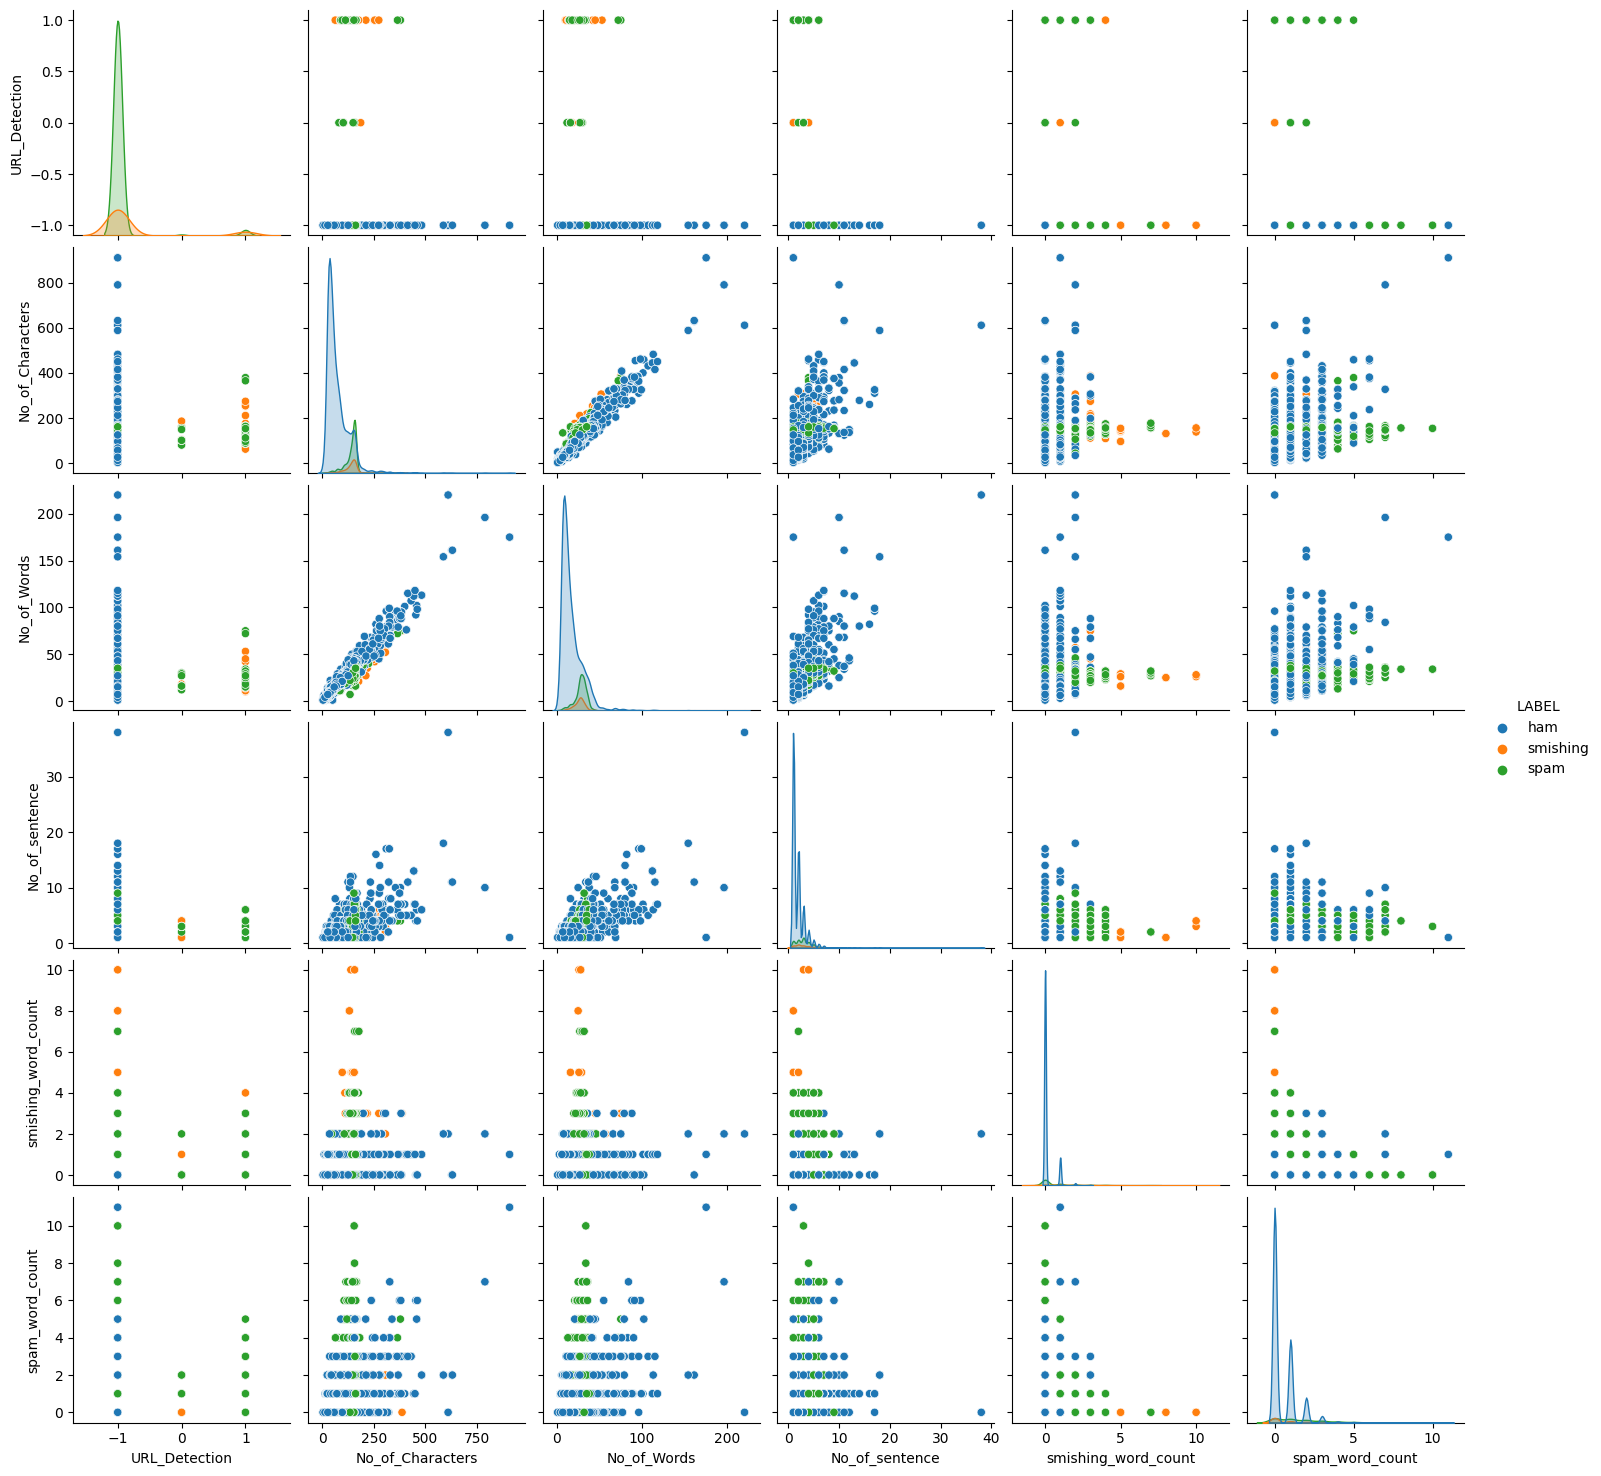

In [24]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="LABEL")
plt.show(fg)

# Outlier Detection

In [25]:
column_names = [(i, col) for i, col in enumerate(df.columns)]
print(column_names)

[(0, 'LABEL'), (1, 'TEXT'), (2, 'URL'), (3, 'EMAIL'), (4, 'PHONE'), (5, 'URL_Detection'), (6, 'domain'), (7, 'No_of_Characters'), (8, 'No_of_Words'), (9, 'No_of_sentence'), (10, 'smishing_word_count'), (11, 'spam_word_count')]


## Look at one feature

In [ ]:
testing_column = column_names[7][1]
sns.displot(df[testing_column])


In [ ]:
import seaborn as sns

sns.boxplot(df[testing_column])

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['figure.dpi'] = 100

df[[testing_column, 'LABEL']].boxplot(by='LABEL', figsize=(20,10))


In [ ]:
# *Dropping the outliers.
df = df[(df[testing_column]<=10)]

df.shape

## Run preset caps

In [26]:
df = df[(df[column_names[7][1]]<=500)]
df = df[(df[column_names[8][1]]<=50)]
df = df[(df[column_names[9][1]]<=10)]
df.shape

(16861, 12)

## *IQR (not finished)

In [33]:
# Extract outliers and remove them
def outliers(df, ft):
    q1 = df[ft].quantile(0.25)
    q3 = df[ft].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.index[(df[ft] > lower_bound) | (df[ft] < upper_bound)]



In [ ]:
# List to store outlier indexes
index_list = []
for feature in ['No_of_Characters', 'No_of_Words', 'No_of_sentence']:
    index_list.extend(outliers(df, feature))

In [ ]:
index_list

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="LABEL")
plt.show(fg)

In [21]:
# Save as JSON
df.to_json('dataset.json', orient='records', lines=True)

# *Cleaning Text
done that earlier for counting words

In [30]:
# Sample of texts before cleaning
print("The First 5 Texts:",*df["TEXT"][:5], sep = "\n")

The First 5 Texts:
whats up do you want me to come online if you are free we can talk sometime
so u workin overtime nigpun
also sir i sent you an email about how to log into the usc payment portal ill send you another message that should explain how things are back home have a great weekend
please stay at home to encourage the notion of staying at home all taxpaying citizens are entitled to 30596 or more emergency refund smsgiofcvbd
bankofamerica alert 137943 please follow httpbitdocgjkand reactivate


In [31]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df.loc[:, "Clean_Text"] = df["TEXT"].apply(Clean)
# Texts after cleaning
print("Texts after cleaning:",*df["Clean_Text"][:5], sep = "\n")

Texts after cleaning:
whats up do you want me to come online if you are free we can talk sometime
so u workin overtime nigpun
also sir i sent you an email about how to log into the usc payment portal ill send you another message that should explain how things are back home have a great weekend
please stay at home to encourage the notion of staying at home all taxpaying citizens are entitled to or more emergency refund smsgiofcvbd
bankofamerica alert please follow httpbitdocgjkand reactivate


## Tokenization

In [32]:
df.loc[:, "Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("Texts after Tokenizing:",*df["Tokenize_Text"][:5], sep = "\n")

Texts after Tokenizing:
['whats', 'up', 'do', 'you', 'want', 'me', 'to', 'come', 'online', 'if', 'you', 'are', 'free', 'we', 'can', 'talk', 'sometime']
['so', 'u', 'workin', 'overtime', 'nigpun']
['also', 'sir', 'i', 'sent', 'you', 'an', 'email', 'about', 'how', 'to', 'log', 'into', 'the', 'usc', 'payment', 'portal', 'ill', 'send', 'you', 'another', 'message', 'that', 'should', 'explain', 'how', 'things', 'are', 'back', 'home', 'have', 'a', 'great', 'weekend']
['please', 'stay', 'at', 'home', 'to', 'encourage', 'the', 'notion', 'of', 'staying', 'at', 'home', 'all', 'taxpaying', 'citizens', 'are', 'entitled', 'to', 'or', 'more', 'emergency', 'refund', 'smsgiofcvbd']
['bankofamerica', 'alert', 'please', 'follow', 'httpbitdocgjkand', 'reactivate']


## Remove Stopwords

In [33]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df.loc[:, "Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)

print("Texts after removing the stopwords:",*df["Nostopword_Text"][:5], sep = "\n")

Texts after removing the stopwords:
['whats', 'want', 'come', 'online', 'free', 'talk', 'sometime']
['u', 'workin', 'overtime', 'nigpun']
['also', 'sir', 'sent', 'email', 'log', 'usc', 'payment', 'portal', 'ill', 'send', 'another', 'message', 'explain', 'things', 'back', 'home', 'great', 'weekend']
['please', 'stay', 'home', 'encourage', 'notion', 'staying', 'home', 'taxpaying', 'citizens', 'entitled', 'emergency', 'refund', 'smsgiofcvbd']
['bankofamerica', 'alert', 'please', 'follow', 'httpbitdocgjkand', 'reactivate']


## Lemmatization

In [34]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    # word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df.loc[:, "Lemmatized_Text"] = df["Nostopword_Text"].apply(lemmatize_word)
print("Texts after lemitization:",*df["Lemmatized_Text"][:5], sep = "\n")

Texts after lemitization:
['whats', 'want', 'come', 'online', 'free', 'talk', 'sometime']
['u', 'workin', 'overtime', 'nigpun']
['also', 'sir', 'send', 'email', 'log', 'usc', 'payment', 'portal', 'ill', 'send', 'another', 'message', 'explain', 'things', 'back', 'home', 'great', 'weekend']
['please', 'stay', 'home', 'encourage', 'notion', 'stay', 'home', 'taxpaying', 'citizens', 'entitle', 'emergency', 'refund', 'smsgiofcvbd']
['bankofamerica', 'alert', 'please', 'follow', 'httpbitdocgjkand', 'reactivate']


## Vectorize

In [35]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in df["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("The First 5 lines in corpus:",*corpus[:5], sep = "\n")

The First 5 lines in corpus:
whats want come online free talk sometime
u workin overtime nigpun
also sir send email log usc payment portal ill send another message explain things back home great weekend
please stay home encourage notion stay home taxpaying citizens entitle emergency refund smsgiofcvbd
bankofamerica alert please follow httpbitdocgjkand reactivate


In [36]:
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature
X.dtype
print(X[:10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [37]:
import pickle

# Save the vectorizer to a file
filename = 'tfidf_vectorizer.pkl'
pickle.dump(tfidf, open(filename, 'wb'))


In [38]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df["LABEL"] = label_encoder.fit_transform(df["LABEL"])

In [39]:
# Save as JSON
df.to_json('df.json', orient='records', lines=True)

# Model Building

In [33]:
# *Load df from JSON
df = pd.read_json('df.json', orient='records', lines=True)

In [40]:
# Setting values for labels and feature as y and X
y = df["LABEL"]

# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Import models

In [41]:
# Models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [42]:
models = [
    ("Naive Bayes multinomial", MultinomialNB()), #naive bayes ones are quick
    #("AdaBoost", AdaBoostClassifier()),
    ("Random Forest", RandomForestClassifier()), #good accurcies
    #("Multi-layer Perceptron", MLPClassifier()), #not working
    ("Naive Bayes multivariate Bernoulli", BernoulliNB()),
    #("Decision Tree", DecisionTreeClassifier()),
    #("KNN", KNeighborsClassifier()), #resource intensive
    ("Logistic Regression", LogisticRegression()),
    ("Support Vector", SVC(probability=True)), #quite slow not tested much
    #("XGBoost", xgb.XGBClassifier())
]

# SVC probability=True is for voting classifer to work

## Fit models

In [47]:
for name, model in models:
  print(f"Training {name}")
  model.fit(X_train, y_train)


Training Naive Bayes multinomial
Training Random Forest
Training Naive Bayes multivariate Bernoulli
Training Logistic Regression
Training Support Vector


In [48]:
# *Pickle the models save the progressxz
for name, model in models:
  filename = f'{name}.pkl'
  pickle.dump(model, open(filename, 'wb'))

In [46]:
# *Load the pickled models
import pickle
# Load each model from its pickle file
for name, model in models:
    filename = f'{name}.pkl'
    with open(filename, 'rb') as file:
        model = pickle.load(file)


## Cross validation

In [49]:
# See label encode

print(df["LABEL"].unique())
print(label_encoder.classes_)


[0 1 2]
['ham' 'smishing' 'spam']


In [50]:
# Cross validation
cv_scores = {}
for name, model in models:
    scoring = metrics.make_scorer(recall_score, average = 'micro', pos_label = 1)
    cv_score = cross_val_score(model, X_train, y_train, scoring = scoring, cv=10)
    print(f"{name}: ", cv_score.mean())
    cv_scores[name] = cv_score.mean()
    

Naive Bayes multinomial:  0.9486949889246459
Random Forest:  0.9510677213366092
Naive Bayes multivariate Bernoulli:  0.9523280240556253
Logistic Regression:  0.942838579187133
Support Vector:  0.9567768629581644


In [51]:
cv_scores

{'Naive Bayes multinomial': 0.9486949889246459,
 'Random Forest': 0.9510677213366092,
 'Naive Bayes multivariate Bernoulli': 0.9523280240556253,
 'Logistic Regression': 0.942838579187133,
 'Support Vector': 0.9567768629581644}

In [ ]:
# Load scores from previous run
cv_scores = {'Naive Bayes multinomial': 0.9486949889246459,
 'Random Forest': 0.9510677213366092,
 'Naive Bayes multivariate Bernoulli': 0.9523280240556253,
 'Logistic Regression': 0.942838579187133,
 'Support Vector': 0.9567768629581644}

In [53]:
# *Pickle the models save progress
for name, model in models:
  filename = f'{name}.pkl'
  pickle.dump(model, open(filename, 'wb'))


## Voting classifyer

In [54]:
total_score = sum(cv_scores[name] for model in models)

In [55]:
weights = {}
for name, score in cv_scores.items():
        weights[name] = score / total_score

weights

{'Naive Bayes multinomial': 0.1983106042074364,
 'Random Forest': 0.19880658869531947,
 'Naive Bayes multivariate Bernoulli': 0.199070036269735,
 'Logistic Regression': 0.19708640868928684,
 'Support Vector': 0.19999999999999998}

In [ ]:
# *Load weights
weights = {'Naive Bayes multinomial': 0.1983106042074364,
 'Random Forest': 0.19880658869531947,
 'Naive Bayes multivariate Bernoulli': 0.199070036269735,
 'Logistic Regression': 0.19708640868928684,
 'Support Vector': 0.19999999999999998}

In [56]:
from sklearn.ensemble import VotingClassifier

weights = [weights[name] for name, _ in models]
votingClassifier = VotingClassifier(estimators=models, voting='soft', weights=weights, verbose=True, n_jobs=-1)
votingClassifier.fit(X_train, y_train)




VotingClassifier(estimators=[('Naive Bayes multinomial', MultinomialNB()),
                             ('Random Forest', RandomForestClassifier()),
                             ('Naive Bayes multivariate Bernoulli',
                              BernoulliNB()),
                             ('Logistic Regression', LogisticRegression()),
                             ('Support Vector', SVC(probability=True))],
                 n_jobs=-1, verbose=True, voting='soft',
                 weights=[0.1983106042074364, 0.19880658869531947,
                          0.199070036269735, 0.19708640868928684,
                          0.19999999999999998])

In [57]:
# Pickle voting model
with open('votingClassifier.pkl', 'wb') as file:
    pickle.dump(votingClassifier, file)

# Evaluating Models

In [58]:
models

[('Naive Bayes multinomial', MultinomialNB()),
 ('Random Forest', RandomForestClassifier()),
 ('Naive Bayes multivariate Bernoulli', BernoulliNB()),
 ('Logistic Regression', LogisticRegression()),
 ('Support Vector', SVC(probability=True))]

In [ ]:
# *Load the pickled models
import pickle

for name, model in models:
  filename = f'{name}.pkl'
  File = open(filename, 'rb')
  model = pickle.load(file)
  print(f"Loaded {name} model{model}")
  models[name] = model


In [ ]:
# *Load the pickled VotingClassifier
with open('votingClassifier.pkl', 'rb') as file:
    votingClassifier = pickle.load(file)

In [50]:
# *Add the VotingClassifier to the models list
models.append(("Voting Classifier", votingClassifier))

In [ ]:
models

In [59]:
# Model Evaluation
# creating lists of varios scores
train_accuracy = []
test_accuracy = []
precision =[]
recall =[]
f1_score = []


# Specify target category as smishing
target_category = 1

for name, model in models:
    print(f"Evaluating {name}")
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # (Ideally I don't want 'werighted' instead of 'binary' and want to focus the target smishing categoty,
    # but the model is multi-class and trying to get it working first)
    prec = metrics.precision_score(y_test, pred_test, pos_label=target_category, average='weighted')
    recal = metrics.recall_score(y_test, pred_test, pos_label=target_category, average='weighted')
    f1_s = metrics.f1_score(y_test, pred_test, pos_label=target_category, average='weighted')

    train_accuracy_score = model.score(X_train,y_train)
    test_accuracy_score = model.score(X_test,y_test)

    #Appending scores
    train_accuracy.append(train_accuracy_score)
    test_accuracy.append(test_accuracy_score)
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)


Evaluating Naive Bayes multinomial
Evaluating Random Forest
Evaluating Naive Bayes multivariate Bernoulli
Evaluating Logistic Regression
Evaluating Support Vector


In [62]:
# Evaluate the voting classifier
pred_train = votingClassifier.predict(X_train)
pred_test = votingClassifier.predict(X_test)


# Ensure that the predictions and true labels are in the correct format
pred_train = pred_train.astype(int)
pred_test = pred_test.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_accuracy_score = accuracy_score(y_train, pred_train)
test_accuracy_score = accuracy_score(y_test, pred_test)
prec = metrics.precision_score(y_test, pred_test, pos_label=target_category, average='weighted')
recal = metrics.recall_score(y_test, pred_test, pos_label=target_category, average='weighted')
f1_s = metrics.f1_score(y_test, pred_test, pos_label=target_category, average='weighted')


#Appending scores
train_accuracy.append(train_accuracy_score)
test_accuracy.append(test_accuracy_score)
precision.append(prec)
recall.append(recal)
f1_score.append(f1_s)

# Print the evaluation metrics
print("Train Accuracy: ", train_accuracy_score)
print("Test Accuracy: ", test_accuracy_score)
print("Precision: ", prec)
print("Recall: ", recal)
print("F1 Score: ", f1_s)


Train Accuracy:  0.9687870699881376
Test Accuracy:  0.9608656981915209
Precision:  0.9607576739684706
Recall:  0.9608656981915209
F1 Score:  0.9519073593689783


In [65]:
# initialise data of lists.
data = {
'train accuracy':train_accuracy,
'test accuracy':test_accuracy,
'Precision':precision,
'Recall':recall,
'F1score':f1_score,
}

evaluate_list = models.append(("Voting Classifier", votingClassifier))

# Extrat model names
model_names = [name for name, _ in models]
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index=model_names)

Results

,train accuracy,test accuracy,Precision,Recall,F1score
Naive Bayes multinomial,0.957814,0.951972,0.956067,0.951972,0.940871
Random Forest,0.977610,0.957901,0.950631,0.957901,0.952249
Naive Bayes multivariate Bernoulli,0.960854,0.955233,0.949229,0.955233,0.948675
Logistic Regression,0.957740,0.949600,0.942699,0.949600,0.941410
Support Vector,0.972642,0.960273,0.953817,0.960273,0.952097
Voting Classifier,0.968787,0.960866,0.960758,0.960866,0.951907


In [66]:
# see scores
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,train accuracy,test accuracy,Precision,Recall,F1score
Naive Bayes multinomial,0.957814,0.951972,0.956067,0.951972,0.940871
Random Forest,0.977610,0.957901,0.950631,0.957901,0.952249
Naive Bayes multivariate Bernoulli,0.960854,0.955233,0.949229,0.955233,0.948675
Logistic Regression,0.957740,0.949600,0.942699,0.949600,0.941410
Support Vector,0.972642,0.960273,0.953817,0.960273,0.952097
Voting Classifier,0.968787,0.960866,0.960758,0.960866,0.951907


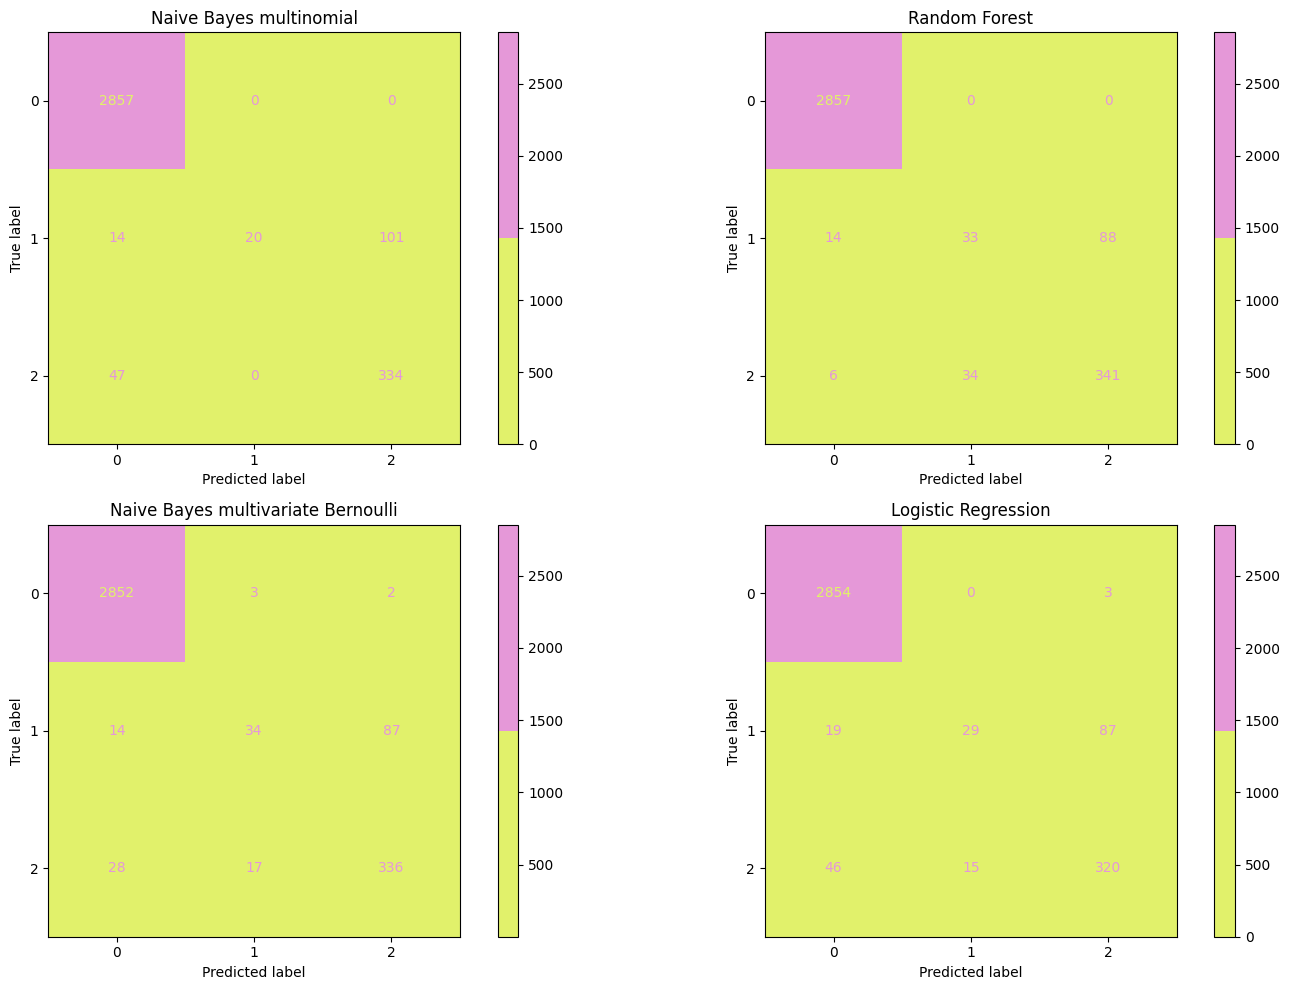

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# Display confusion matrix for each model
for (name, model), ax in zip(models, axes.flatten()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax, cmap=cmap)
    ax.title.set_text(name)

plt.tight_layout()
plt.show()